# Pump It Up: Data Mining the Water Table (Competition)
## DrivenData.org Practice Competition

**Can you predict which water pumps are faulty?**

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### Reference:
DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved July 17, 2024 from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, \
                                    GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, accuracy_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
!pip install optuna

import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [49]:
!pip install Catboost
from catboost import CatBoostClassifier, Pool, cv

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
train_label = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/DD Pump It Up/train_labels.csv')
train_features = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/DD Pump It Up/train_values.csv')
test_features = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/DD Pump It Up/test_values.csv')
submission = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/DD Pump It Up/SubmissionFormat.csv')

Mounted at /content/drive


In [4]:
# Joining `status_group` to other features on column `id`
train_df = pd.merge(train_features, train_label, on='id')
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Apply Preprocessing Steps
## Part A:
- Everything before OHE and LE for Random Forest
- Ready for LGBM and CatBoost

## Part B:
- Additional preprocessing for Random Forest

In [5]:
# Convert 'region_code' and 'district_code' to type 'object'
train_df['region_code'] = train_df['region_code'].astype('object')
train_df['district_code'] = train_df['district_code'].astype('object')
train_df['construction_year'] = train_df['construction_year'].astype('object')

test_features['region_code'] = test_features['region_code'].astype('object')
test_features['district_code'] = test_features['district_code'].astype('object')
test_features['construction_year'] = test_features['construction_year'].astype('object')

# Convert 'date_recorded' into year, month, day columns
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded'])
train_df['year_recorded'] = train_df['date_recorded'].dt.year
train_df['month_recorded'] = train_df['date_recorded'].dt.month
train_df['day_recorded'] = train_df['date_recorded'].dt.day

test_features['date_recorded'] = pd.to_datetime(test_features['date_recorded'])
test_features['year_recorded'] = test_features['date_recorded'].dt.year
test_features['month_recorded'] = test_features['date_recorded'].dt.month
test_features['day_recorded'] = test_features['date_recorded'].dt.day

# Log Transform 'amount_tsh' and 'population'
train_df['amount_tsh_log'] = np.log1p(train_df['amount_tsh'])
train_df['population_log'] = np.log1p(train_df['population'])
test_features['amount_tsh_log'] = np.log1p(test_features['amount_tsh'])
test_features['population_log'] = np.log1p(test_features['population'])

# Drop unneccessary columns
train_df = train_df.drop(
    columns=[
        'num_private', 'recorded_by',               # irrelevant
        'date_recorded',                            # new features made
        'amount_tsh', 'population',                 # log transformed
])

test_features = test_features.drop(
    columns=[
        'id',
        'num_private', 'recorded_by',               # irrelevant
        'date_recorded',                            # new features made
        'amount_tsh', 'population',                 # log transformed
])

In [6]:
# Split `train_df` into train and test sets before additional encoding
# to prevent data leakage
X = train_df.drop(columns=['status_group','id'], axis=1)
y = train_df['status_group']

# Split train_df into 80% train and 20% test, stratified by y ('status_group')
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42)

In [8]:
# Impute 0 values in 'longitude' and 'latitude'
region_medians = X_train.groupby('region_code')[['longitude', 'latitude']].median()

#Impute missing values in the training set where longitude or latitude is ~0
X_train['longitude'] = X_train.apply(
    lambda row: region_medians.loc[row['region_code'], 'longitude'] \
    if row['longitude'] == 0 else row['longitude'], axis=1
)

X_train['latitude'] = X_train.apply(
    lambda row: region_medians.loc[row['region_code'], 'latitude'] \
    if row['latitude'] == -2.000000e-08 else row['latitude'], axis=1
)

# Apply the same imputation to the test set using medians from the training set
X_test['longitude'] = X_test.apply(
    lambda row: region_medians.loc[row['region_code'], 'longitude'] \
    if row['longitude'] == 0 else row['longitude'], axis=1
)
X_test['latitude'] = X_test.apply(
    lambda row: region_medians.loc[row['region_code'], 'latitude'] \
    if row['latitude'] == -2.000000e-08 else row['latitude'], axis=1
)

# Apply the same imputation to the test set using medians from the training set
test_features['longitude'] = test_features.apply(
    lambda row: region_medians.loc[row['region_code'], 'longitude'] \
    if row['longitude'] == 0 else row['longitude'], axis=1
)
test_features['latitude'] = test_features.apply(
    lambda row: region_medians.loc[row['region_code'], 'latitude'] \
    if row['latitude'] == -2.000000e-08 else row['latitude'], axis=1
)

# Fill Categorical Columns with missing values in X_train, X_test,
# and test_features with 'missing'
categorical_columns = X.select_dtypes(include=['object']).columns

X_train[categorical_columns] = X_train[categorical_columns].fillna('missing')
X_test[categorical_columns] = X_test[categorical_columns].fillna('missing')
test_features[categorical_columns] = (
    test_features[categorical_columns].fillna('missing'))

In [10]:
%%time
# Replace infrequent columns in 'funder', 'installer', and 'wpt_name'
# if less than threshold. Can adjust value in future iterations

# Define the columns to be transformed
columns_to_transform = [
    'funder',
    'installer',
    'wpt_name',
    'subvillage',
    'scheme_name',
    'ward'
]

# Function to replace infrequent categories with 'INFREQUENT'
def replace_infrequent_categories(df, columns, threshold=30):
    for column in columns:
        value_counts = df[column].value_counts()
        to_replace = value_counts[value_counts <= threshold].index
        df[column] = df[column].replace(to_replace, 'INFREQUENT')
    return df

# Apply the function to X_train, X_test, and test_features
X_train = replace_infrequent_categories(X_train, columns_to_transform)
X_test = replace_infrequent_categories(X_test, columns_to_transform)
test_features = replace_infrequent_categories(test_features, columns_to_transform)

CPU times: user 1min 53s, sys: 132 ms, total: 1min 53s
Wall time: 1min 53s


# PART B
### OneHotEncoding & LabelEncoding for Random Forest

In [11]:
# Threshold for OneHotEncoding
threshold = 200

# Identify categorical features and their unique value counts
categorical_features = X_train.select_dtypes(include=['object']).columns
category_counts = X_train[categorical_features].nunique()

# Separate features based on the threshold
onehot_features = category_counts[category_counts < threshold].index.tolist()
labelencode_features = category_counts[category_counts >= threshold].index.tolist()

# Convert boolean features to strings
X_train[onehot_features] = X_train[onehot_features].astype(str)
X_test[onehot_features] = X_test[onehot_features].astype(str)

# Apply OneHotEncoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = ohe.fit_transform(X_train[onehot_features])
X_test_ohe = ohe.transform(X_test[onehot_features])

# Do the same for test_features
test_features[onehot_features] = test_features[onehot_features].astype(str)
test_features_ohe = ohe.transform(test_features[onehot_features])

In [12]:
# Apply Label Encoding (if needed)
label_encoders = {}
for col in labelencode_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))  # To string
    # Use fit_transform on X_test to handle unseen labels
    X_test[col] = X_test[col].astype(str).map(
        lambda s: 'unknown' if s not in le.classes_ else s)  # To string
    le.classes_ = np.append(le.classes_, 'unknown')
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Combine OneHotEncoded and LabelEncoded features with numeric features
X_train_encoded = pd.DataFrame(
    X_train_ohe, columns=ohe.get_feature_names_out(onehot_features))

X_test_encoded = pd.DataFrame(
    X_test_ohe, columns=ohe.get_feature_names_out(onehot_features))

X_train_final = pd.concat([
    X_train_encoded.reset_index(drop=True),
    X_train[labelencode_features + X.select_dtypes(include=['number'])
    .columns.tolist()].reset_index(drop=True)], axis=1)

X_test_final = pd.concat([
    X_test_encoded.reset_index(drop=True),
    X_test[labelencode_features + X.select_dtypes(include=['number'])
    .columns.tolist()].reset_index(drop=True)], axis=1)

print(f"Number of features after encoding: {X_train_final.shape[1]}")

# Label Encode for test_features
for col in labelencode_features:
    if col in test_features.columns:
        le = label_encoders[col]
        test_features[col] = test_features[col].map(
            lambda s: 'unknown' if s not in le.classes_ else s)
        le.classes_ = np.append(le.classes_, 'unknown')
        test_features[col] = le.transform(test_features[col])

test_features_encoded = pd.DataFrame(
    test_features_ohe, columns=ohe.get_feature_names_out(onehot_features))

test_features_final = pd.concat(
    [test_features_encoded.reset_index(drop=True),
     test_features[
         labelencode_features + X.select_dtypes(include=['number'])
         .columns.tolist()].reset_index(drop=True)], axis=1)

Number of features after encoding: 834


## Cross-validation

In [ ]:
# Setup StratifiedKFold
stratified_kfold = StratifiedKFold(
    n_splits=1, # should be 5
    shuffle=True,
    random_state=42
)

# Random Forest Classifier

In [19]:
# Do not run unless you want to wait a long time

# Define the objective function for Random Forest
def rf_objective(trial):
    rf_param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 75),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_float('max_features', 0.7, 1.0),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    model = RandomForestClassifier(**rf_param_grid, random_state=42)
    score = cross_val_score(
        model, X_train_final, y_train, cv=2, scoring='accuracy').mean()
    return score

# Create a study and optimize
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=25)

# Best parameters for Random Forest
rf_best_params = rf_study.best_params
print("Best RF parameters: ", rf_best_params)

[I 2024-08-29 21:37:20,855] A new study created in memory with name: no-name-7b09a350-4c81-4b20-a07d-39a97b8c5c6b
[I 2024-08-29 21:43:11,757] Trial 0 finished with value: 0.7959385521885523 and parameters: {}. Best is trial 0 with value: 0.7959385521885523.


Best RF parameters:  {}


In [21]:
base_rf_model = RandomForestClassifier(random_state=42)

rf_model = RandomForestClassifier(
    criterion='entropy',
    max_depth=69,
    max_features=0.7385480758096516,
    min_samples_leaf=3,
    min_samples_split=9,
    n_estimators=250,
    n_jobs=-1,
    random_state=42,
)

base_rf_scores = cross_val_score(
    base_rf_model, X_train_final, y_train,
    cv=stratified_kfold,
    scoring='f1_weighted')

rf_scores = cross_val_score(
    rf_model, X_train_final, y_train,
    cv=stratified_kfold,
    scoring='f1_weighted')

In [22]:
print(base_rf_scores)
print("Base Random Forest mean score: ", base_rf_scores.mean())
print()
print(rf_scores)
print("Tuned Random Forest mean score: ", rf_scores.mean())

[0.79638227 0.78790063 0.79745848 0.7901507  0.79329381]
Base Random Forest mean score:  0.7930371757441208

[0.80069661 0.79425147 0.80320501 0.79193882 0.80036262]
Tuned Random Forest mean score:  0.7980909052288615


In [24]:
# Train the final model on the entire training data using the best hyperparameters
rf_model.fit(X_train_final, y_train)

RandomForestClassifier(criterion='entropy', max_depth=69,
                       max_features=0.7385480758096516, min_samples_leaf=3,
                       min_samples_split=9, n_estimators=250, n_jobs=-1,
                       random_state=42)

In [25]:
rf_preds = rf_model.predict(X_test_final)

print(f"Accuracy: {accuracy_score(y_test, rf_preds)}")
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))

Accuracy: 0.8085016835016835
Random Forest Classification Report:
                          precision    recall  f1-score   support

             functional       0.79      0.91      0.85      6452
functional needs repair       0.64      0.27      0.38       863
         non functional       0.85      0.77      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.76      0.65      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



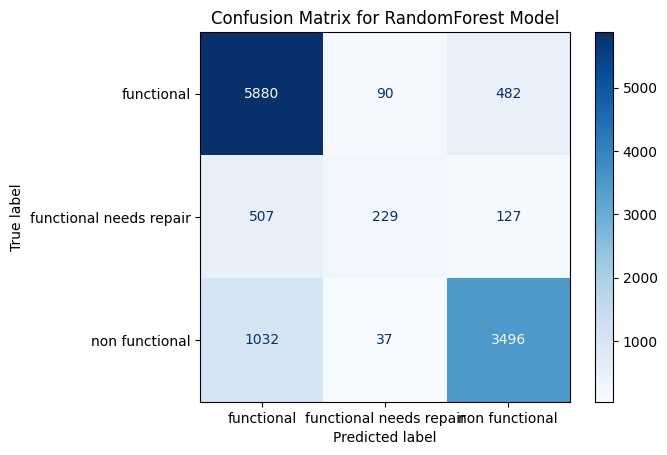

In [26]:
# Generate confusion matrix
rf_cm = confusion_matrix(y_test, rf_preds)

# Display confusion matrix
rf_disp = ConfusionMatrixDisplay(
    confusion_matrix=rf_cm, display_labels=rf_model.classes_)

rf_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for RandomForest Model')
plt.show()

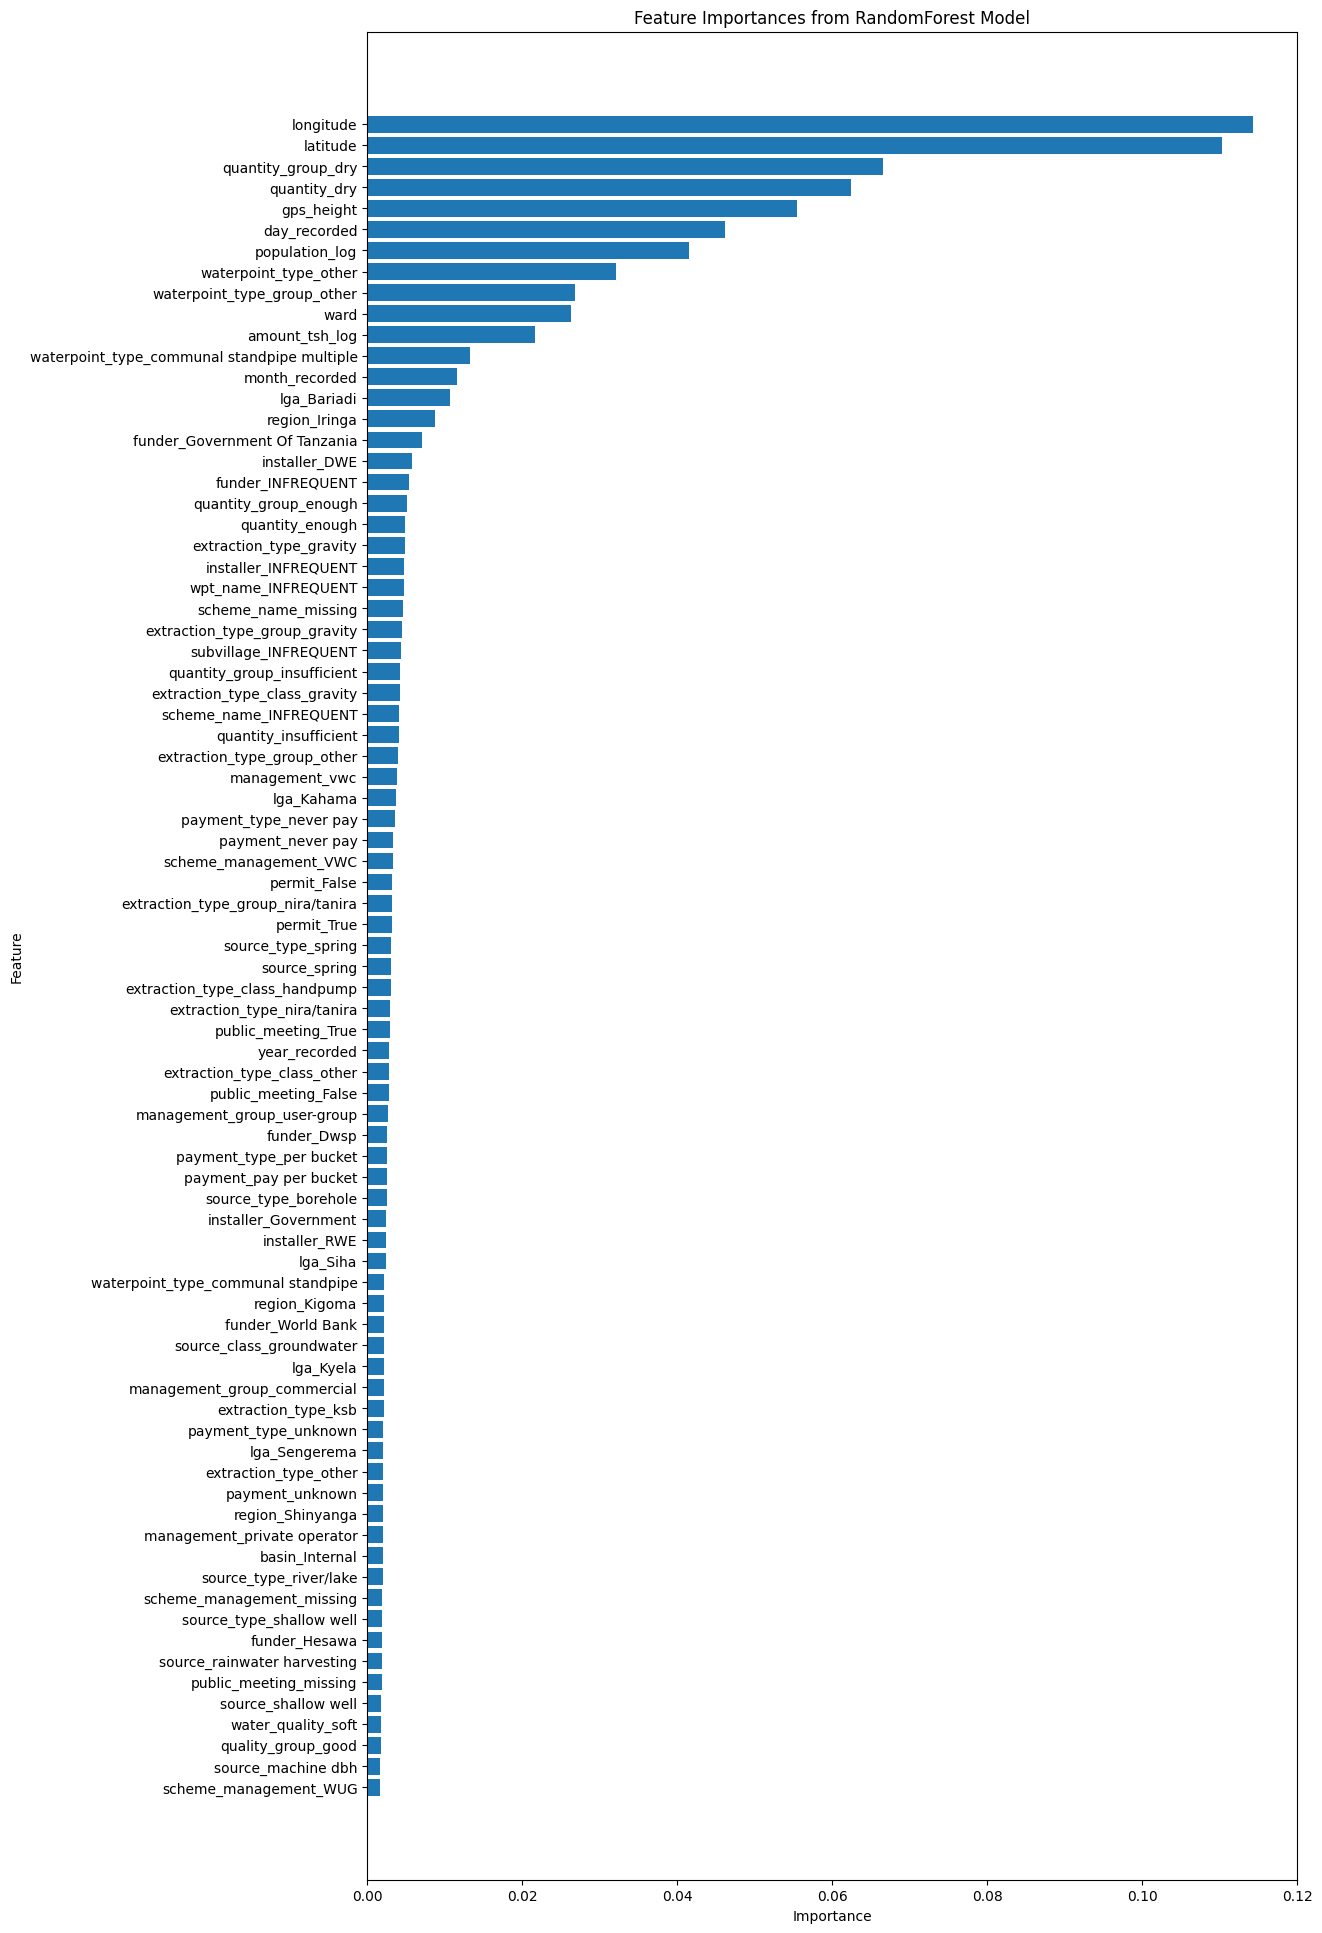

In [27]:
# Get feature importances from the best RandomForest model
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_features_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': rf_feature_importances
})

# Sort the DataFrame by importance
rf_features_df = rf_features_df.sort_values(
    by='Importance', ascending=False).head(80)

# Plot the feature importances
plt.figure(figsize=(12, 24))
plt.barh(rf_features_df['Feature'], rf_features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForest Model')
plt.gca().invert_yaxis()
plt.show()

In [28]:
# Train on full data before predictions
X_final = pd.concat([X_train_final, X_test_final], axis=0)
y_final = pd.concat([y_train, y_test], axis=0)

rf_model.fit(X_final, y_final)

RandomForestClassifier(criterion='entropy', max_depth=69,
                       max_features=0.7385480758096516, min_samples_leaf=3,
                       min_samples_split=9, n_estimators=250, n_jobs=-1,
                       random_state=42)

In [29]:
# Predict using RandomForest model
rf_test_preds = rf_model.predict(test_features_final)

# Replace values in 'status_group' with rf_test_preds
submission['status_group'] = rf_test_preds

#submission.to_csv('submission_rf.csv', index=False)

# LGBM
- Let's convert features with datatype of 'object' to 'categorical' first.

In [30]:
# Convert from 'object' to 'category' dtypes
X_train_cat = X_train.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)
X_test_cat = X_test.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)
test_features_cat = test_features.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)

In [ ]:
# Do not run unless you want to wait a long time

# Define the objective function for LightGBM
def lgbm_objective(trial):
    lgbm_param_grid = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 70),
        'max_depth': trial.suggest_int('max_depth', 10, 75),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.5)
    }

    model = LGBMClassifier(**lgbm_param_grid)
    score = cross_val_score(model, X_train_cat, y_train, cv=3, scoring='accuracy').mean()
    return score

# Create a study and optimize
lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=25)

# Best parameters for LightGBM
lgbm_best_params = lgbm_study.best_params
print("Best LGBM parameters: ", lgbm_best_params)

In [31]:
# Base model
base_lgbm_model = LGBMClassifier(random_state=42)

# Best hyperparameters
lgbm_best_params = {
    'num_leaves': 59,
    'max_depth': 44,
    'learning_rate': 0.041786677018894554,
    'n_estimators': 824,
    'min_child_samples': 45,
    'subsample': 0.7662423547244932,
    'colsample_bytree': 0.7460637441592799,
    'reg_alpha': 0.001169447139534055,
    'reg_lambda': 0.23281199844208145
}

lgbm_model = LGBMClassifier(
    **lgbm_best_params,
    n_jobs=-1,
    random_state=42,
)

# Cross-validation
base_lgbm_scores = cross_val_score(
    base_lgbm_model, X_train_cat, y_train,
    cv=stratified_kfold,
    scoring='f1_weighted')

lgbm_scores = cross_val_score(
    lgbm_model, X_train_cat, y_train,
    cv=stratified_kfold,
    scoring='f1_weighted')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2306
[LightGBM] [Info] Number of data points in the train set: 38016, number of used features: 39
[LightGBM] [Info] Start training from score -0.610534
[LightGBM] [Info] Start training from score -2.621328
[LightGBM] [Info] Start training from score -0.956506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 38016, number of used features: 39
[LightGBM] [Info] Start training from score -0.610534
[LightGBM] [Info] Start training from score -2.621690
[LightGBM] [Info] Start 

In [32]:
print(base_lgbm_scores)
print("Base LGBM mean score: ", base_lgbm_scores.mean())
print()
print(lgbm_scores)
print("Tuned LGBM mean score: ", lgbm_scores.mean())

[0.78536561 0.78267209 0.79619946 0.78038074 0.78649105]
Base LGBM mean score:  0.7862217904626638

[0.79961573 0.79866838 0.80958745 0.78943794 0.79876852]
Tuned LGBM mean score:  0.7992156037241311


In [33]:
# Add categorical_feature='auto' (similar to CatBoost)
lgbm_model.fit(
    X_train_cat, y_train,
    categorical_feature='auto'
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2311
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 39
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.956493


LGBMClassifier(colsample_bytree=0.7460637441592799,
               learning_rate=0.041786677018894554, max_depth=44,
               min_child_samples=45, n_estimators=824, n_jobs=-1, num_leaves=59,
               random_state=42, reg_alpha=0.001169447139534055,
               reg_lambda=0.23281199844208145, subsample=0.7662423547244932)

In [35]:
lgbm_preds = lgbm_model.predict(X_test_cat)
print(f"Accuracy: {accuracy_score(y_test, lgbm_preds)}")
print("LightGBM Classification Report:\n",
      classification_report(y_test, lgbm_preds))

Accuracy: 0.803956228956229
LightGBM Classification Report:
                          precision    recall  f1-score   support

             functional       0.79      0.90      0.84      6452
functional needs repair       0.60      0.30      0.40       863
         non functional       0.84      0.76      0.80      4565

               accuracy                           0.80     11880
              macro avg       0.75      0.65      0.68     11880
           weighted avg       0.80      0.80      0.79     11880



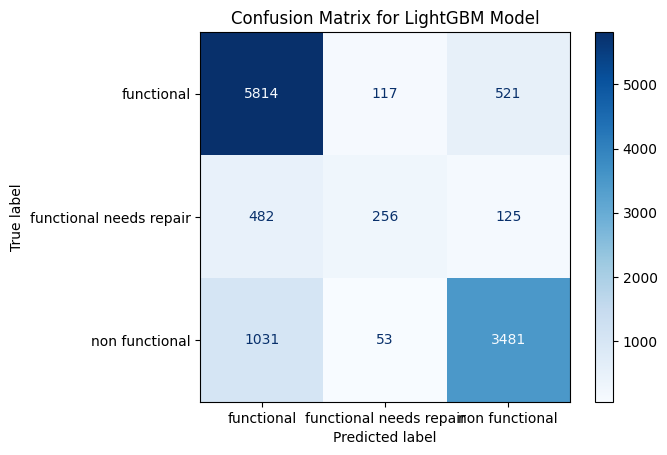

In [36]:
# Generate confusion matrix
lgbm_cm = confusion_matrix(y_test, lgbm_preds)

# Display confusion matrix
lgbm_disp = ConfusionMatrixDisplay(
    confusion_matrix=lgbm_cm,
    display_labels=lgbm_model.classes_)
lgbm_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for LightGBM Model')
plt.show()

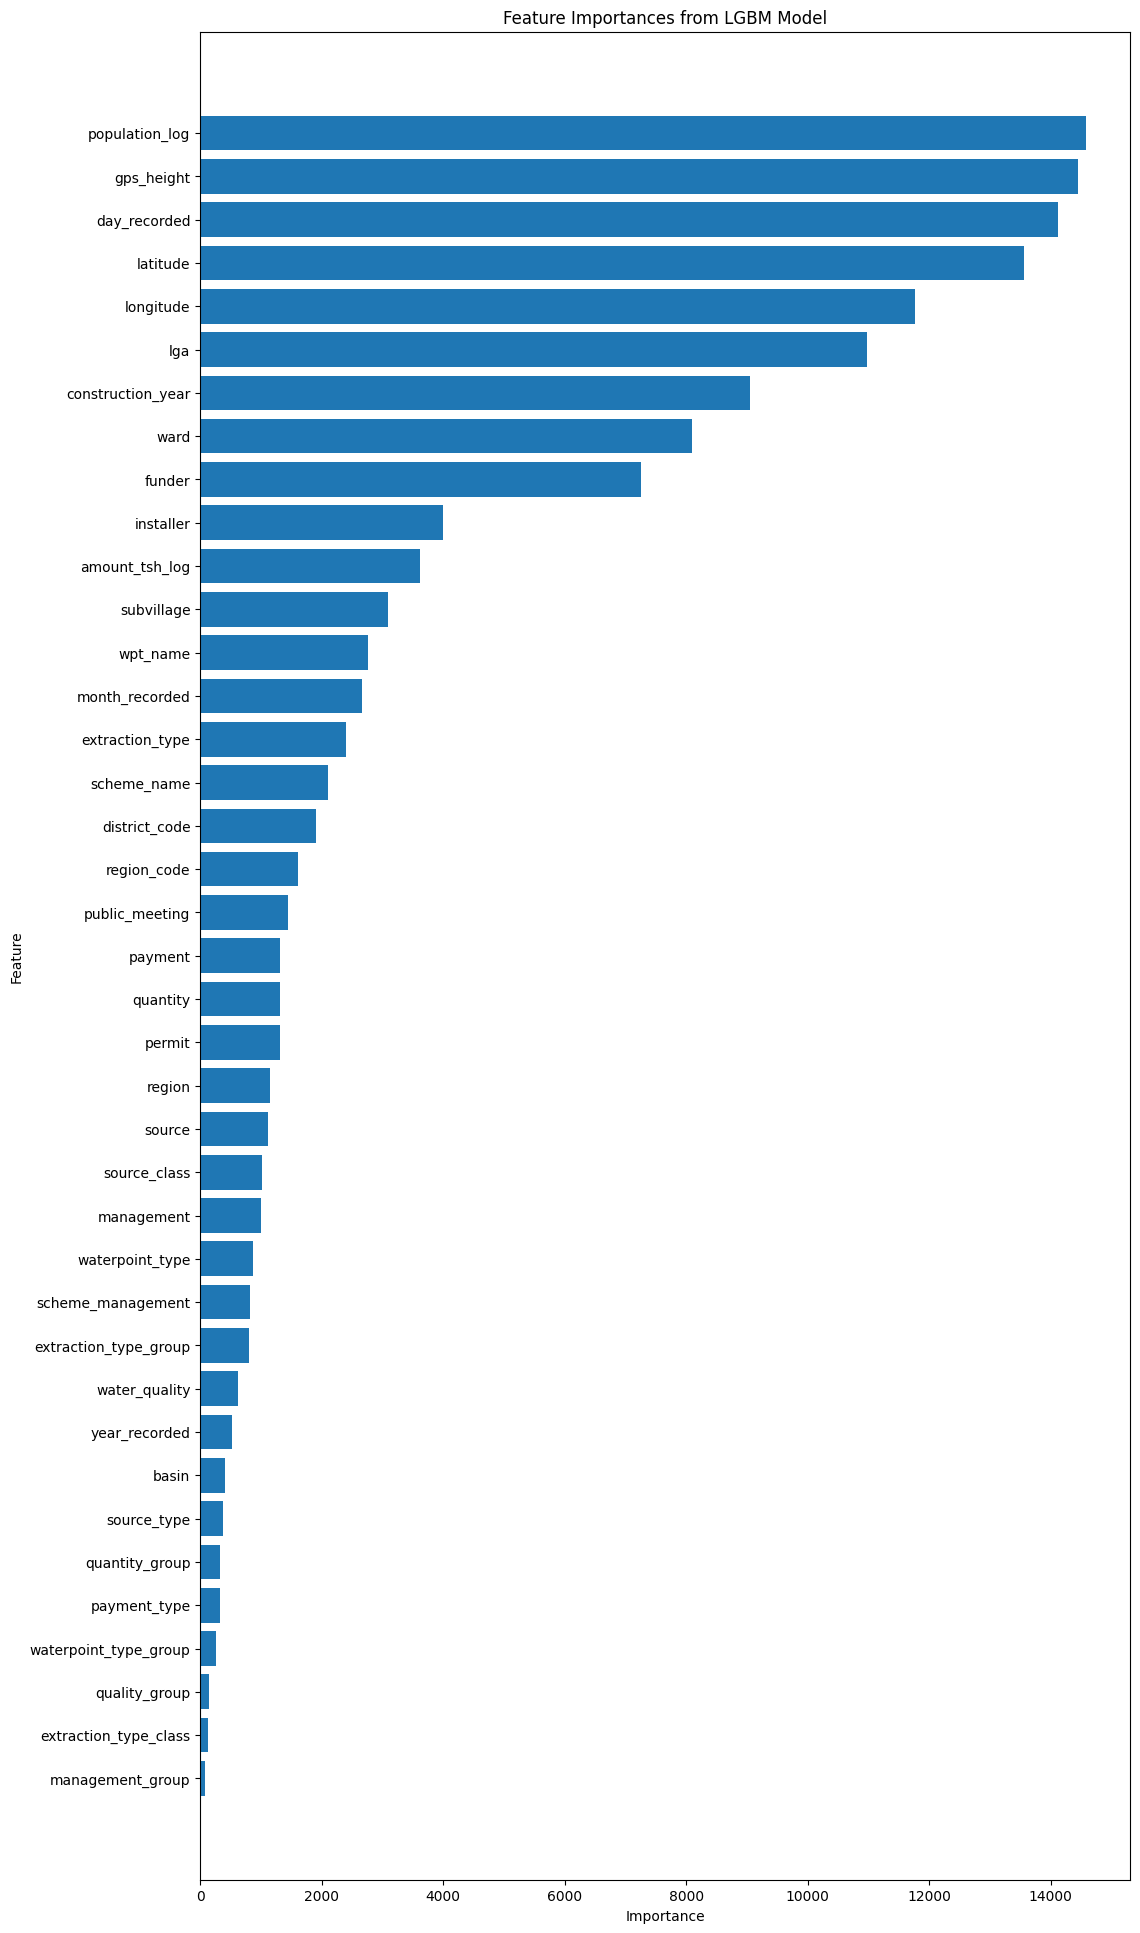

In [38]:
# Get feature importances from the best RandomForest model
lgbm_feature_importances = lgbm_model.feature_importances_

# Create a DataFrame for better visualization
lgbm_features_df = pd.DataFrame({
    'Feature': X_train_cat.columns,
    'Importance': lgbm_feature_importances
})

# Sort the DataFrame by importance
lgbm_features_df = lgbm_features_df.sort_values(
    by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 24))
plt.barh(lgbm_features_df['Feature'], lgbm_features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from LGBM Model')
plt.gca().invert_yaxis()
plt.show()

In [39]:
# Train on full data before predictions
X_final_cat = pd.concat([X_train_cat, X_test_cat], axis=0)

# Convert back to 'category' dtype
X_final_cat = X_final_cat.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)

lgbm_model.fit(X_final_cat, y_final)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 59400, number of used features: 39
[LightGBM] [Info] Start training from score -0.610497
[LightGBM] [Info] Start training from score -2.621734
[LightGBM] [Info] Start training from score -0.956482


LGBMClassifier(colsample_bytree=0.7460637441592799,
               learning_rate=0.041786677018894554, max_depth=44,
               min_child_samples=45, n_estimators=824, n_jobs=-1, num_leaves=59,
               random_state=42, reg_alpha=0.001169447139534055,
               reg_lambda=0.23281199844208145, subsample=0.7662423547244932)

In [40]:
# Predict using LGBM model
lgbm_test_preds = lgbm_model.predict(test_features_cat)

submission['status_group'] = lgbm_test_preds

#submission.to_csv('submission_lgbm.csv', index=False)

# CatBoost

In [43]:
# Identify categorical feature indices
categorical_features_indices = [
    X.columns.get_loc(col) for col in X.select_dtypes(
        include=['object']).columns]

# Create a Pool
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

In [47]:
# Define parameter grid
cb_param_grid = {
    'iterations': [2000],
    'depth': [9],                       #[6, 9, 12],
    'learning_rate': [0.05],            #[0.01, 0.05, 0.1],
    'l2_leaf_reg': [4],                 #[1, 4, 7],
    'auto_class_weights': ['Balanced'], #['Balanced', None],
    'one_hot_max_size': [200]           #[150, 200]
}

# Initialize CatBoost model
cb_base_model = CatBoostClassifier(
    random_state=42,
    verbose=False,
    task_type='GPU'
)

# Perform grid search
cb_gscv = cb_base_model.grid_search(
    cb_param_grid,
    train_pool,
    cv=2, #should be 5
    verbose=False
)

# Access the best parameters
cb_best_params = cb_gscv['params']
print(f'Best parameters: {cb_best_params}')

bestTest = 0.6294887378
bestIteration = 1389
Training on fold [0/2]
bestTest = 0.6847440425
bestIteration = 752
Training on fold [1/2]
bestTest = 0.6767978172
bestIteration = 811
Best parameters: {'depth': 9, 'auto_class_weights': 'Balanced', 'one_hot_max_size': 200, 'learning_rate': 0.05, 'l2_leaf_reg': 4, 'iterations': 2000}


Note:
- `auto_class_weights = 'Balanced'` gives a more balanced model, identifying the weakest class better, but it had an worse score overall, so we will remove it for the purpose of the competition

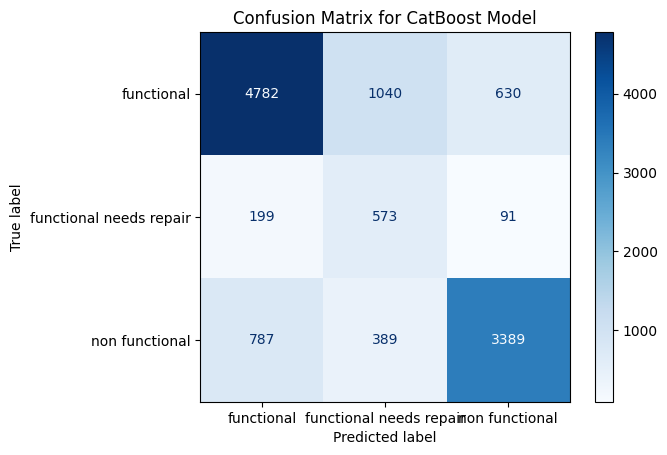

In [50]:
# Cross-validation
cb_params = {
    'depth': 9,
    #'auto_class_weights': 'Balanced',
    'one_hot_max_size': 200,
    'learning_rate': 0.05,
    'l2_leaf_reg': 4,
    'iterations': 2000,
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
    'random_seed': 42,
    'logging_level': 'Silent',
    'od_type': 'Iter',
    'od_wait': 50,
    'task_type':'GPU'
}

cb_cv_results = cv(
    pool=train_pool,
    params=cb_params,
    fold_count=5,             # Number of folds
    shuffle=True,             # Shuffle data before splitting into folds
    partition_random_seed=42, # Seed for reproducibility
    stratified=True,          # Stratified sampling to ensure class balance
    verbose=False
)

In [51]:
# Cross-validation Results
cb_cv_results

,iterations,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
0,0,1.061135,0.000302,1.060815,0.000037
1,1,1.027873,0.000585,1.027286,0.000299
2,2,0.998190,0.000585,0.997180,0.000349
3,3,0.971397,0.000687,0.970124,0.000216
4,4,0.947082,0.001075,0.945514,0.000457
...,...,...,...,...,...
1995,1995,0.493510,0.005532,0.367025,0.001071
1996,1996,0.493499,0.005518,0.366992,0.001089
1997,1997,0.493493,0.005530,0.366937,0.001067
1998,1998,0.493488,0.005525,0.366898,0.001062


In [52]:
# Initialize and Fit CatBoost model
cb_model = CatBoostClassifier(
    **cb_params
)

cb_model.fit(
    train_pool,
    eval_set=[(X_test, y_test)],
    verbose=False
)

In [53]:
# Evaluate the best model
cb_preds = cb_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, cb_preds)}')
print(classification_report(y_test, cb_preds))

Accuracy: 0.8015151515151515
                         precision    recall  f1-score   support

             functional       0.78      0.91      0.84      6452
functional needs repair       0.64      0.26      0.37       863
         non functional       0.85      0.75      0.80      4565

               accuracy                           0.80     11880
              macro avg       0.76      0.64      0.67     11880
           weighted avg       0.80      0.80      0.79     11880



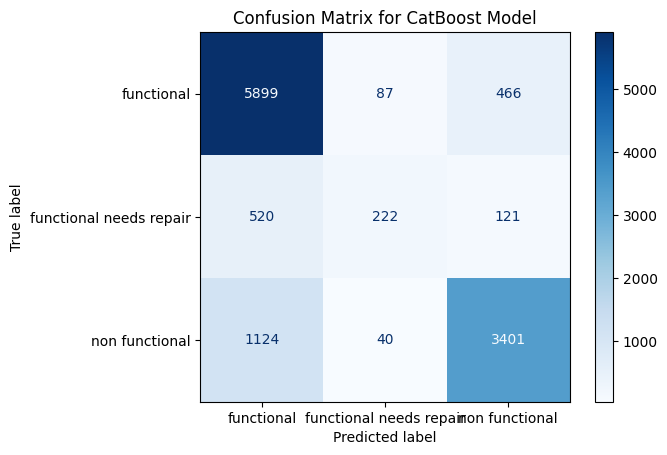

In [54]:
# Generate confusion matrix
cb_cm = confusion_matrix(y_test, cb_preds)

# Display confusion matrix
cb_disp = ConfusionMatrixDisplay(confusion_matrix=cb_cm,
                              display_labels=cb_model.classes_)
cb_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for CatBoost Model')
plt.show()

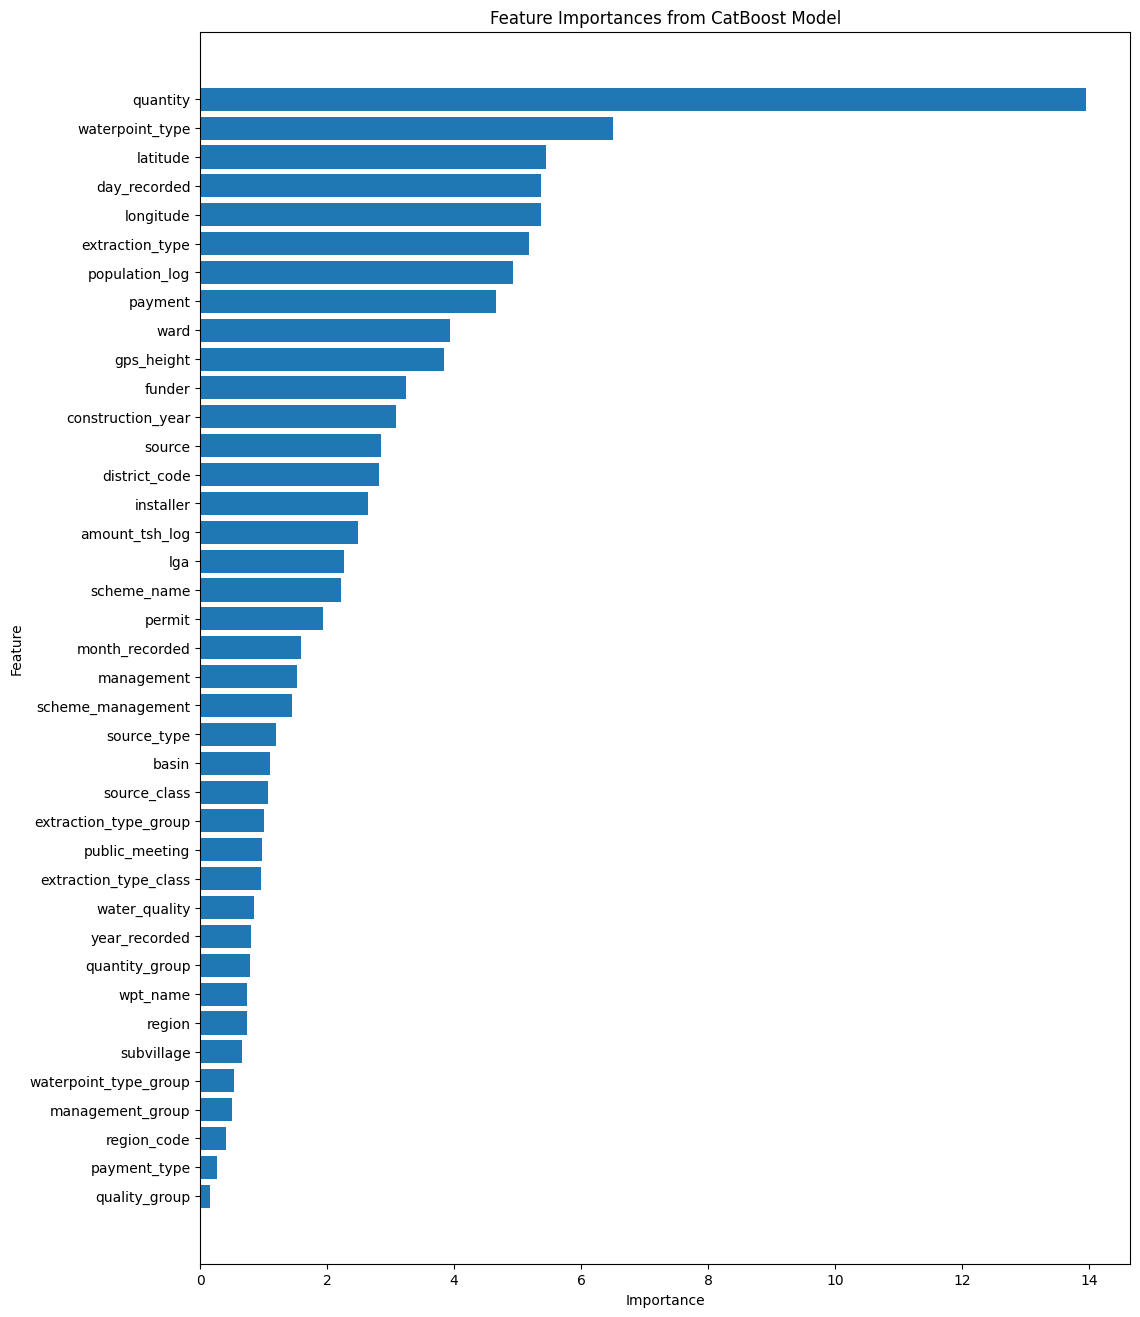

In [55]:
# Get feature importances from the CatBoost model
cb_feature_importances = cb_model.get_feature_importance()

# Create a DataFrame for better visualization
cb_features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cb_feature_importances
})

# Sort the DataFrame by importance
cb_features_df = cb_features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 16))
plt.barh(cb_features_df['Feature'], cb_features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

In [56]:
# Train on full data before predictions
X_final_cb = pd.concat([X_train, X_test], axis=0)
y_final_cb = pd.concat([y_train, y_test], axis=0)

cb_model.fit(
    Pool(X_final_cb, y_final_cb, cat_features=categorical_features_indices),
    eval_set=[]
)

In [57]:
# Predict using CatBoost model
cb_test_preds = cb_model.predict(test_features)

# Replace values in 'status_group' with catboost_test_preds
submission['status_group'] = cb_test_preds.flatten()

#submission.to_csv('submission_cb.csv', index=False)

# Scoring Diary
- Steps 1 to 6 uses `test_size=0.3` and `n_fold=10`
- Steps 7+ uses `test_size=0.2` and `n_fold=5`

1) Base RF with training on ALL train data (.8102)
- Drop minimal features
- Original Preprocessing (threshold 50)
  - less than threshold = 'Other'
- RF (seed 42, depth 25)
- **Original Preprocessing > New Preprocessing**

2) Base RF (.8094)
- Drop `wpt_name` and `scheme_name`
  - Reduced score
- **Keep features**

3) Base RF (.8077)
- Drop duplicate features but kept `wpt_name` and `scheme_name`
  - Reduced score further
- **Keep features**

4) Previous HP Tuned RF on ALL train data (.8155)
- Kept all features
- Used HP Tuned RF from previous model (via Optuna)
- **Use HP Tuning**

5) HP Tuned RF (.8156)
- Log transformed `amount_tsh` and `population`
- **Transform features**

6) HP Tuned RF (.8159)
- Imputed zero values for `longitude` and `latitude`
- **Impute features**

7) HP Tuned LGBM (.8042)
- RF preprocessing steps but used LGBM
- 80/20 TTS
- Error: Because of 80/20 split, used LE for `ward`
  - Made model WORSE in both CV and TTS
- **Try LGBM OHE**

8) ~HP Tuned CB (.7973)
- RF preprocessing steps but used CB
- 80/20 TTS
- Error: Because of 80/20 split, used LE for `ward`
- **Try CB OHE**

9) HP Tuned LGBM (.8126)
- Converted 'object' to 'categorical' dtype from X_train (X_train_cat)
- Used `categorical_feature='auto'`
- Kept 80/20 TTS
- **LGBM: use internal OHE**

10) HP Tuned CB (.7634)
- Used CB's grid_search
- `auto_class_weights='Balanced'` helped with 'functional needs repair'
- But overall accuracy score dropped to ~0.73
- Consider keeping for soft voting?

11) HP Tuned CB (.8069)
- **Remove `auto_class_weights`**

12) HP Tuned CB (.8088)
- **Add `one_hot_max_size=200`**

13) HP Tuned RF (.8157)
- **70/30 TTS was higher score**

14) Soft Voting (.8207)
- **Balanced Classes (1/3 each)**

15) Soft Voting (.8203)
- Weighted .37/.33/.30

16) Soft Voting w/ Threshold 30 (.8212)
- **Changed threshold for 'INFREQUENT' to 30**

17) Soft Voting w/ Threshold 10 (.8191)
- Not as good as 30

18) Soft Voting w/ `num_private` feature (.8205)
- Made worse; good to drop feature